# Imphadel 
#### Decision Tree Model for Detecting Malicious Windows Executable Files based on Metadata

## Requirements



For Data Collection Process
1. MacOs or Ubuntu Device with 7zip installed for malware samples collection
2. Clean Windows Device for clean samples collection

For Other Proceeses
1. Any system will work

## Introduction

### PE File

Portable Executable (PE) is a file format used in Microsoft Windows operating systems to store executable code, libraries, and other resources such as icons and bitmaps. PE files consist of several sections, including the header, text section, data section, resource section, and import section. The header section contains metadata about the file, including the file size, entry point, and the addresses of each section. The text section contains the executable code, while the data section contains initialized and uninitialized data used by the program.

The import section of the PE file is particularly relevant for malware detection. This section lists the functions that the executable code needs to call from external libraries or DLLs (Dynamic Link Libraries) to run correctly. Malware authors often use the import section to hide their malicious code by modifying the names or addresses of the functions they import. As a result, malware detection tools may struggle to identify these functions as malicious.

This is where machine learning models based on imported functions can be beneficial. These models use the information in the import section to analyze the functions that are being imported and their parameters. They then use this information to identify patterns that are indicative of malicious behavior.

For example, a machine learning model may look for functions that are commonly used by malware, such as those used to download or execute additional files, disable security software, or steal sensitive information. By analyzing the import section and the parameters used by these functions, the model can identify potential threats and alert the user or take action to mitigate the risk.

Overall, machine learning models based on imported functions can provide an additional layer of protection against malware by analyzing the metadata of PE files and identifying potential threats that may be missed by traditional signature-based detection techniques.

### Imphash vs Model

Both machine learning models based on imported functions and the imphash technique are used to analyze the import section of PE files for malware detection. However, there are some key differences between the two.

Imphash is a hash-based technique that calculates a unique identifier for each PE file based on the functions that are imported. It does this by hashing the names of the imported functions and their addresses. This creates a unique identifier, known as the imphash, that can be compared to a database of known malicious hashes to identify potential threats.

One advantage of imphash is that it is a fast and efficient technique that can quickly analyze large volumes of PE files. However, there are some limitations to this approach. For example, imphash may not be effective against polymorphic malware that changes the function names or addresses, or against malware that uses encryption or other obfuscation techniques to hide its import section. Another example is that malware writers can import unnecessary functions to mess with the hash.

In contrast, machine learning models based on imported functions can be more effective at identifying these types of malware. These models use algorithms to analyze the functions being imported and their parameters, rather than relying solely on the hash values. This allows them to identify patterns and behaviors that may be indicative of malicious activity, even if the function names or addresses have been obfuscated.

Another advantage of machine learning models is that they can be trained on large datasets of both malicious and benign samples, allowing them to learn and adapt to new threats over time. This can make them more effective at identifying new and emerging threats, as well as improving their overall accuracy and reducing false positives.

Overall, both imphash and machine learning models based on imported functions have their strengths and weaknesses. While imphash is a useful and efficient technique, it may not be effective against all types of malware. Machine learning models, on the other hand, can be more effective at identifying polymorphic and obfuscated malware, and can improve over time with additional training data.






## Data Collection Process

You can skip this part and use my data set here:  
https://drive.google.com/drive/folders/1YC5eVfVavxwNeZd-Olfd1VsX8IFLhPZS?usp=sharing

### Collecting 1000 exe malware samples from Malware Bazaar using its API


This script will download exe malware and store it in ./zipped folder
Please note that Malware Bazaar limit its download limit to 1000 samples per week per IP address. Therefore, this script should only be run once.

In [ ]:
import requests
import json

data = {
    'query': 'get_file_type',
    'file_type': 'exe',
    'limit': '1000'
}

list_response = requests.post('https://mb-api.abuse.ch/api/v1/', data=data)
list_response_json = json.loads(list_response.text)

sample_count = 1
for sample in list_response_json['data']:
    data = {
        'query': 'get_file',
        'sha256_hash': sample['sha256_hash']
    }

    response = requests.post('https://mb-api.abuse.ch/api/v1/', data=data)
    with open(f'zipped/sample{sample_count:03d}.zip', 'wb') as f:
        f.write(response.content)
    sample_count += 1

The downloaded samples are in the format of password-protected zip file, therefore the following script will extract the exe samples and store it in ./infected folder. 

In [ ]:
import subprocess
import os
import shutil

#Replace the path here
SEVEN_ZIP_PATH = "/usr/local/bin/7zz"

sample_count = 1
while sample_count <= 1000:
    subprocess.call([ SEVEN_ZIP_PATH, "x", "-pinfected", f"zipped/sample{sample_count:03d}.zip"])
    for file in os.listdir("./"):
        if file.endswith('.exe'):
            src_file = os.path.join(file)
            dst_file = f"infected/sample{sample_count:03d}.exe"
            shutil.move(src_file, dst_file)
            sample_count += 1
            break

### Collecting Clean Executable Samples


This script is meant to be run on an uninfected Windows System, not here!  
```
import os
import shutil

source_dir = "C:\\"

dest_dir = ".\\clean"

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith(".exe"):
            src_file_path = os.path.join(root, file)
            dest_file_path = os.path.join(dest_dir, file)
            shutil.copy2(src_file_path, dest_file_path)
            print(f"Copied {src_file_path} to {dest_file_path}")
print("Done copying exe files")
```

This script will collect all exe files in the system it is being run on. Please note that it does not guarantee any sample count; it might need to be run on multiple devices to collect near 1000 samples.  
Once its done, transfer the 'safe' folder to the current directory of this notebook.

### Extracting the Metadata from the executable files

In [1]:
%pip install pefile pandas


[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


For Malicious Exes

In [2]:
import os
import pefile
import pandas as pd

# Define the metadata fields to extract
metadata = {"machine_type": [],
            "date_created": [],
            "number_of_sections": [],
            "section_alignment": [],
            "file_alignment": [],
            "image_size": [],
            "headers_size": [],
            "subsystem_type": [],
            "imported_dlls": [],
            "imported_functions": []}

# Iterate over the files in the directory
for filename in os.listdir("./infected"):
    if filename.endswith(".exe"):
        filepath = os.path.join("./infected", filename)

        # Open the PE file
        pe = pefile.PE(filepath)

        # Extract the metadata fields
        metadata["machine_type"].append(pefile.MACHINE_TYPE.get(pe.FILE_HEADER.Machine, "Unknown"))
        metadata["date_created"].append(pe.FILE_HEADER.TimeDateStamp)
        metadata["number_of_sections"].append(pe.FILE_HEADER.NumberOfSections)
        metadata["section_alignment"].append(pe.OPTIONAL_HEADER.SectionAlignment)
        metadata["file_alignment"].append(pe.OPTIONAL_HEADER.FileAlignment)
        metadata["image_size"].append(pe.OPTIONAL_HEADER.SizeOfImage)
        metadata["headers_size"].append(pe.OPTIONAL_HEADER.SizeOfHeaders)
        metadata["subsystem_type"].append(pefile.SUBSYSTEM_TYPE.get(pe.OPTIONAL_HEADER.Subsystem, "Unknown"))
        metadata["imported_dlls"].append(",".join([entry.dll.decode() for entry in pe.DIRECTORY_ENTRY_IMPORT]) if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT') else "")
        metadata["imported_functions"].append(",".join([f.name.decode() for entry in pe.DIRECTORY_ENTRY_IMPORT for f in entry.imports if f.name is not None]) if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT') else "")
        
        # Close the PE file
        pe.close()

# Create the DataFrame
df_mal = pd.DataFrame(metadata)

df_mal.head()

,machine_type,date_created,number_of_sections,section_alignment,file_alignment,image_size,headers_size,subsystem_type,imported_dlls,imported_functions
0,IMAGE_FILE_MACHINE_I386,1468633330,5,4096,512,1007616,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,"ADVAPI32.dll,KERNEL32.dll,GDI32.dll,USER32.dll...","GetTokenInformation,RegDeleteValueA,RegOpenKey..."
1,IMAGE_FILE_MACHINE_I386,3226397388,3,8192,512,770048,512,IMAGE_SUBSYSTEM_WINDOWS_GUI,mscoree.dll,_CorExeMain
2,IMAGE_FILE_MACHINE_AMD64,3344059323,2,8192,512,2170880,512,IMAGE_SUBSYSTEM_WINDOWS_GUI,,
3,IMAGE_FILE_MACHINE_I386,1468633330,5,4096,512,741376,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,"ADVAPI32.dll,KERNEL32.dll,GDI32.dll,USER32.dll...","GetTokenInformation,RegDeleteValueA,RegOpenKey..."
4,IMAGE_FILE_MACHINE_I386,1468633330,5,4096,512,856064,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,"ADVAPI32.dll,KERNEL32.dll,GDI32.dll,USER32.dll...","GetTokenInformation,RegDeleteValueA,RegOpenKey..."


In [3]:
df_mal.to_csv('infected.csv', index=False)

For Clean exe

In [4]:
# Clear metadata
metadata = {"machine_type": [],
            "date_created": [],
            "number_of_sections": [],
            "section_alignment": [],
            "file_alignment": [],
            "image_size": [],
            "headers_size": [],
            "subsystem_type": [],
            "imported_dlls": [],
            "imported_functions": []}

for filename in os.listdir("./safe"):
    if filename.endswith(".exe"):
        filepath = os.path.join("./safe", filename)

        try:
            # Open the PE file
            pe = pefile.PE(filepath)

            # Extract the metadata fields
            metadata["machine_type"].append(pefile.MACHINE_TYPE.get(pe.FILE_HEADER.Machine, "Unknown"))
            metadata["date_created"].append(pe.FILE_HEADER.TimeDateStamp)
            metadata["number_of_sections"].append(pe.FILE_HEADER.NumberOfSections)
            metadata["section_alignment"].append(pe.OPTIONAL_HEADER.SectionAlignment)
            metadata["file_alignment"].append(pe.OPTIONAL_HEADER.FileAlignment)
            metadata["image_size"].append(pe.OPTIONAL_HEADER.SizeOfImage)
            metadata["headers_size"].append(pe.OPTIONAL_HEADER.SizeOfHeaders)
            metadata["subsystem_type"].append(pefile.SUBSYSTEM_TYPE.get(pe.OPTIONAL_HEADER.Subsystem, "Unknown"))
            metadata["imported_dlls"].append(",".join([entry.dll.decode() for entry in pe.DIRECTORY_ENTRY_IMPORT]) if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT') else "")
            metadata["imported_functions"].append(",".join([f.name.decode() for entry in pe.DIRECTORY_ENTRY_IMPORT for f in entry.imports if f.name is not None]) if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT') else "")
            
            # Close the PE file
            pe.close()
        
        except pefile.PEFormatError as e:
            print(f"Skipping {filepath}: {e}")
            continue
        

# Create the DataFrame
df_safe = pd.DataFrame(metadata)

df_safe.head()

Skipping ./safe/eqnedt32.exe: 'The file is empty'


,machine_type,date_created,number_of_sections,section_alignment,file_alignment,image_size,headers_size,subsystem_type,imported_dlls,imported_functions
0,IMAGE_FILE_MACHINE_AMD64,1676906954,6,4096,512,69632,1024,IMAGE_SUBSYSTEM_WINDOWS_CUI,"KERNEL32.dll,ole32.dll,OLEAUT32.dll,MSVCP140.d...","GetLastError,InitializeCriticalSectionEx,Delet..."
1,IMAGE_FILE_MACHINE_I386,1538728210,5,4096,512,3407872,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,"KERNEL32.dll,USER32.dll,GDI32.dll,MSIMG32.dll,...","GetStringTypeW,GetTimeZoneInformation,GetConso..."
2,IMAGE_FILE_MACHINE_AMD64,1768684448,6,4096,512,98304,1024,IMAGE_SUBSYSTEM_WINDOWS_CUI,"ADVAPI32.dll,KERNEL32.dll,msvcrt.dll,ole32.dll...","RegQueryValueExW,InitiateSystemShutdownExW,Ope..."
3,IMAGE_FILE_MACHINE_AMD64,1599554788,2,8192,512,344064,512,IMAGE_SUBSYSTEM_WINDOWS_CUI,,
4,IMAGE_FILE_MACHINE_I386,4278777568,5,4096,512,94208,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,"KERNEL32.dll,USER32.dll,msvcrt.dll,ADVAPI32.dll","CreateFileMappingW,LoadResource,FindResourceEx..."


In [5]:
df_safe.to_csv('safe.csv', index=False)

## Data Exploration

### Malicious Samples

In [6]:
df_mal.shape

(998, 10)

In [7]:
df_mal.head()

,machine_type,date_created,number_of_sections,section_alignment,file_alignment,image_size,headers_size,subsystem_type,imported_dlls,imported_functions
0,IMAGE_FILE_MACHINE_I386,1468633330,5,4096,512,1007616,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,"ADVAPI32.dll,KERNEL32.dll,GDI32.dll,USER32.dll...","GetTokenInformation,RegDeleteValueA,RegOpenKey..."
1,IMAGE_FILE_MACHINE_I386,3226397388,3,8192,512,770048,512,IMAGE_SUBSYSTEM_WINDOWS_GUI,mscoree.dll,_CorExeMain
2,IMAGE_FILE_MACHINE_AMD64,3344059323,2,8192,512,2170880,512,IMAGE_SUBSYSTEM_WINDOWS_GUI,,
3,IMAGE_FILE_MACHINE_I386,1468633330,5,4096,512,741376,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,"ADVAPI32.dll,KERNEL32.dll,GDI32.dll,USER32.dll...","GetTokenInformation,RegDeleteValueA,RegOpenKey..."
4,IMAGE_FILE_MACHINE_I386,1468633330,5,4096,512,856064,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,"ADVAPI32.dll,KERNEL32.dll,GDI32.dll,USER32.dll...","GetTokenInformation,RegDeleteValueA,RegOpenKey..."


In [8]:
df_mal.describe()

,date_created,number_of_sections,section_alignment,file_alignment,image_size,headers_size
count,9.980000e+02,998.000000,998.000000,998.000000,9.980000e+02,998.000000
mean,1.723537e+09,4.357715,5885.467936,602.325651,6.392474e+06,1338.869739
std,6.520090e+08,2.080934,5039.981252,562.836714,1.983384e+07,5033.902408
min,0.000000e+00,1.000000,1.000000,1.000000,1.920000e+02,416.000000
25%,1.468633e+09,3.000000,4096.000000,512.000000,3.850240e+05,512.000000
50%,1.658589e+09,4.000000,4096.000000,512.000000,7.372800e+05,1024.000000
75%,1.681909e+09,5.000000,8192.000000,512.000000,1.442816e+06,1024.000000
max,4.227269e+09,18.000000,65536.000000,4096.000000,2.099118e+08,65536.000000


In [9]:
# Assuming your dataframe is named 'df_mal'
empty_string_rows = (df_mal == '').sum()
print("Number of rows with empty strings for each column:")
for column, count in empty_string_rows.items():
    print(f"{column}: {count}")

Number of rows with empty strings for each column:
machine_type: 0
date_created: 0
number_of_sections: 0
section_alignment: 0
file_alignment: 0
image_size: 0
headers_size: 0
subsystem_type: 0
imported_dlls: 117
imported_functions: 123


In [10]:
# Assuming your dataframe is named 'df_mal'
df_mal = df_mal[df_mal['imported_dlls'] != '']

df_mal.shape

(881, 10)

### Non-Malicious Samples

In [11]:
df_safe.shape

(799, 10)

In [12]:
empty_string_rows = (df_safe == '').sum()
print("Number of rows with empty strings for each column:")
for column, count in empty_string_rows.items():
    print(f"{column}: {count}")

Number of rows with empty strings for each column:
machine_type: 0
date_created: 0
number_of_sections: 0
section_alignment: 0
file_alignment: 0
image_size: 0
headers_size: 0
subsystem_type: 0
imported_dlls: 36
imported_functions: 36


In [13]:
# Assuming your dataframe is named 'df_mal'
df_safe = df_safe[df_safe['imported_dlls'] != '']

df_safe.shape

(763, 10)

## Data Preprocessing

We need to downsample the malicious samples to match the sample size of the clean samples

In [14]:
df_mal = df_mal.head(763)

Now that we have loaded our raw data into two dataframes df_mal and df_safe, we can start preprocessing by setting y label to both dataframes then combine them

In [15]:
df_mal['is_mal'] = 1
df_safe['is_mal'] = 0
df_combined = pd.concat([df_safe, df_mal], ignore_index=True)
df_combined = df_combined.reset_index(drop=True)
df_combined.head(5)

,machine_type,date_created,number_of_sections,section_alignment,file_alignment,image_size,headers_size,subsystem_type,imported_dlls,imported_functions,is_mal
0,IMAGE_FILE_MACHINE_AMD64,1676906954,6,4096,512,69632,1024,IMAGE_SUBSYSTEM_WINDOWS_CUI,"KERNEL32.dll,ole32.dll,OLEAUT32.dll,MSVCP140.d...","GetLastError,InitializeCriticalSectionEx,Delet...",0
1,IMAGE_FILE_MACHINE_I386,1538728210,5,4096,512,3407872,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,"KERNEL32.dll,USER32.dll,GDI32.dll,MSIMG32.dll,...","GetStringTypeW,GetTimeZoneInformation,GetConso...",0
2,IMAGE_FILE_MACHINE_AMD64,1768684448,6,4096,512,98304,1024,IMAGE_SUBSYSTEM_WINDOWS_CUI,"ADVAPI32.dll,KERNEL32.dll,msvcrt.dll,ole32.dll...","RegQueryValueExW,InitiateSystemShutdownExW,Ope...",0
3,IMAGE_FILE_MACHINE_I386,4278777568,5,4096,512,94208,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,"KERNEL32.dll,USER32.dll,msvcrt.dll,ADVAPI32.dll","CreateFileMappingW,LoadResource,FindResourceEx...",0
4,IMAGE_FILE_MACHINE_I386,1646598958,5,4096,512,106496,1024,IMAGE_SUBSYSTEM_WINDOWS_CUI,"KERNEL32.dll,USER32.dll,SHELL32.dll,ADVAPI32.dll","Sleep,GetExitCodeThread,GetModuleHandleW,GetPr...",0


### Splitting Data and Encoding

From the previous code block, we can see that the values in 'Imported DLLs', 'Imported functions', and 'Exported symbols' are stored as a list of string in csv format, we need to split and encode them.

In [16]:
%pip install scikit-learn


[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

# Assuming your DataFrame is named df_combined

# Splitting the strings into lists
df_combined['imported_dlls'] = df_combined['imported_dlls'].apply(lambda x: x.split(',') if x else [])
df_combined['imported_functions'] = df_combined['imported_functions'].apply(lambda x: x.split(',') if x else [])

# Encoding the columns
mlb = MultiLabelBinarizer()

encoded_imported_dlls = pd.DataFrame(mlb.fit_transform(df_combined['imported_dlls']), columns=mlb.classes_, index=df_combined.index)
encoded_imported_functions = pd.DataFrame(mlb.fit_transform(df_combined['imported_functions']), columns=mlb.classes_, index=df_combined.index)

# Concatenating the encoded columns with the original dataframe
df_combined_encoded = pd.concat([df_combined, encoded_imported_dlls, encoded_imported_functions], axis=1)

# Dropping the original columns
df_combined_encoded = df_combined_encoded.drop(['imported_dlls', 'imported_functions'], axis=1)
df_combined_encoded.head()

,machine_type,date_created,number_of_sections,section_alignment,file_alignment,image_size,headers_size,subsystem_type,is_mal,3DViewer.dll,...,wtap_uses_lua_filehandler,wtap_write_shb_comment,wvsprintfA,wvsprintfW,xtime_get,zipClose,zipCloseFileInZip,zipOpen,zipOpenNewFileInZip3_64,zipWriteInFileInZip
0,IMAGE_FILE_MACHINE_AMD64,1676906954,6,4096,512,69632,1024,IMAGE_SUBSYSTEM_WINDOWS_CUI,0,0,...,0,0,0,0,0,0,0,0,0,0
1,IMAGE_FILE_MACHINE_I386,1538728210,5,4096,512,3407872,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,0,0,...,0,0,0,0,0,0,0,0,0,0
2,IMAGE_FILE_MACHINE_AMD64,1768684448,6,4096,512,98304,1024,IMAGE_SUBSYSTEM_WINDOWS_CUI,0,0,...,0,0,0,0,0,0,0,0,0,0
3,IMAGE_FILE_MACHINE_I386,4278777568,5,4096,512,94208,1024,IMAGE_SUBSYSTEM_WINDOWS_GUI,0,0,...,0,0,0,0,0,0,0,0,0,0
4,IMAGE_FILE_MACHINE_I386,1646598958,5,4096,512,106496,1024,IMAGE_SUBSYSTEM_WINDOWS_CUI,0,0,...,0,0,0,0,0,0,0,0,0,0


Now We have to encode the remaining columns with string value

In [18]:
# One-hot encoding for 'Name', 'Subsystem', and 'DLL characteristics' columns
df_combined_encoded = pd.get_dummies(df_combined_encoded, columns=['machine_type', 'subsystem_type'])

In [19]:
from sklearn.model_selection import train_test_split

# Preparing the dataset
X = df_combined_encoded.drop('is_mal', axis=1)
y = df_combined_encoded['is_mal']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

There is a problem with this, however. There are too many features in this model. We have to select the top 50 features

In [20]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
tree = DecisionTreeClassifier()

# Fit the decision tree on your training data
tree.fit(X_train, y_train)

# Create a feature selector based on the decision tree model
selector = SelectFromModel(tree, max_features=50)

# Apply feature selection to the training set
X_train_selected = selector.transform(X_train)

# Apply feature selection to the testing/validation set
X_test_selected = selector.transform(X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [21]:
# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Include the index of the 'is_mal' column
selected_feature_indices = [df_combined_encoded.columns.get_loc('is_mal')] + list(selected_feature_indices)

# Subset the original dataframe with the selected features
df_selected_features = df_combined_encoded.iloc[:, selected_feature_indices]
df_selected_features

,is_mal,date_created,number_of_sections,image_size,headers_size,ADVAPI32.DLL,MPR.DLL,VERSION.DLL,WS2_32.DLL,obs.dll,...,_mktime64,_unlink,lroundf,lstrcpy,memcmp,read_prefs_file,wcrtomb,machine_type_IMAGE_FILE_MACHINE_ARM64,subsystem_type_IMAGE_SUBSYSTEM_NATIVE,subsystem_type_IMAGE_SUBSYSTEM_WINDOWS_CUI
0,0,1676906954,6,69632,1024,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1538728210,5,3407872,1024,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1768684448,6,98304,1024,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,4278777568,5,94208,1024,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1646598958,5,106496,1024,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521,1,1468633330,5,745472,1024,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1522,1,1679659444,5,798720,1024,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1523,1,1468633330,5,602112,1024,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1524,1,1468633330,5,602112,1024,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Saving data and data_dict

In [22]:
data_dict = {}

df_selected_features.to_csv('data.csv', index=False)

# Iterate over columns in the DataFrame
for column in df_selected_features.columns:
    # Get the data type of the column
    data_type = str(df_selected_features[column].dtype)
    
    # Store the data type in the data dictionary
    data_dict[column] = data_type

# Save the data dictionary to a text file
with open("data_dict.txt", "w") as file:
    for column, data_type in data_dict.items():
        file.write(f"{column}: {data_type}\n")


## Model

In [23]:
import numpy as np
from yellowbrick.model_selection import ValidationCurve
import matplotlib.pyplot as plt

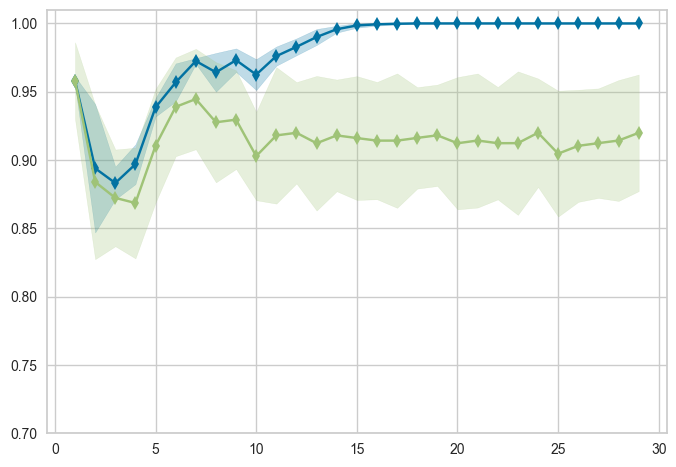

In [24]:
param_range = np.arange(1, 30, 1)
visualizer = ValidationCurve(
    DecisionTreeClassifier(),param_name="max_depth",
    param_range=param_range, cv=10, scoring='recall'
)
visualizer.fit(X_train_selected, y_train)
plt.ylim(0.7, 1.01)
plt.show()

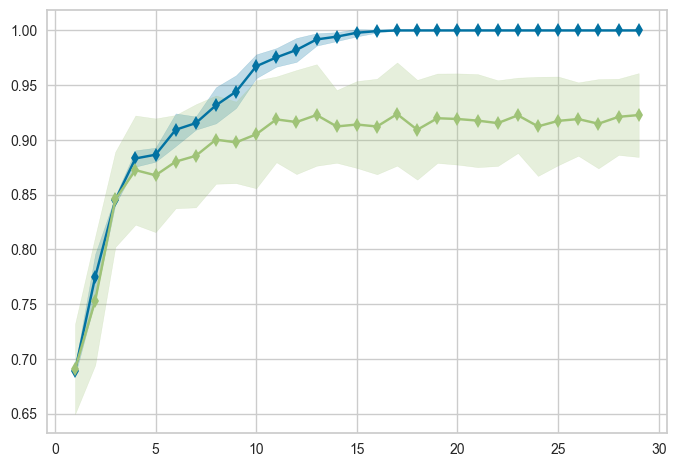

In [25]:
param_range = np.arange(1, 30, 1)
visualizer = ValidationCurve(
    DecisionTreeClassifier(),param_name="max_depth",
    param_range=param_range, cv=10, scoring='precision'
)
visualizer.fit(X_train_selected, y_train)
plt.show()

The following code trains the decision tree model and also uses GridSearchCV to find maximum recall.  
Please note that we are using recall as the main metric because we are building a malware detection tool.  
The main purpose of malware detection is to avoid malware to be run on the user computer, hence, reducing the False Negative(FN) is the best approach.

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Create a decision tree classifier
tree = DecisionTreeClassifier(random_state=100)

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [7],
}

# Create a GridSearchCV object with the decision tree classifier and parameter grid
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=10)

# Fit the grid search to the training data
grid_search.fit(X_train_selected, y_train)

# Get the best estimator and best parameters from the grid search
best_tree = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test set
y_pred = best_tree.predict(X_test_selected)


Confusion Matrix:
[[190  30]
 [ 12 226]]
Classification Report: 
               precision    recall  f1-score   support

        Safe       0.94      0.86      0.90       220
     Malware       0.88      0.95      0.91       238

    accuracy                           0.91       458
   macro avg       0.91      0.91      0.91       458
weighted avg       0.91      0.91      0.91       458
 

Accuracy on train:   0.941 

Accuracy on test:  0.908 



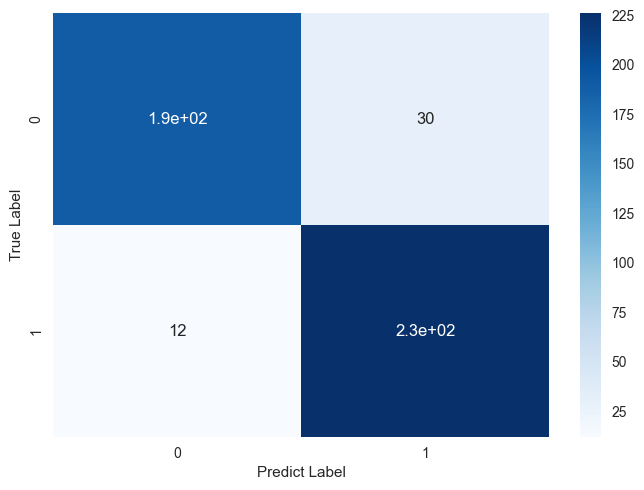

In [30]:
import seaborn as sns
from sklearn import metrics

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report: \n", metrics.classification_report(y_test,y_pred,target_names=['Safe', 'Malware']),'\n')
print("Accuracy on train:  ",best_tree.score(X_train_selected,y_train).round(3),'\n')
print("Accuracy on test: ",best_tree.score(X_test_selected,y_test).round(3),'\n')
cf=metrics.confusion_matrix(y_test,y_pred).round(3)
sns.heatmap(cf,annot=True,cmap='Blues')
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

#### Saving Model for later use

In [28]:
import pickle

# Save the trained model and the column names to a file
with open("decision_tree_model_and_columns.pkl", "wb") as file:
    pickle.dump((best_tree, X_train.columns), file)